# Extraction of features

In this script, we will extract effort-related features from the merged multimodal trial data. 

Because we are dealing with time-varying data, we will extract number of statistics that characterize both instantaneous as well as cumulative nature of each (acoustic, motion, postural) timeseries. These are:

- global mean and standard deviation
- number, mean and standard deviation of the peaks (using function `find_peaks` from `scipy.signal`)
- range of the values
- integral of selected timeseries
- xxx

Additionally, we will compute sample entropy to measure a complexity of a timeseries.

Furthermore, we will utilize measurements that capture characteristics beyond the statistics sketched above. These include:

- intermittency (as a dimensionless jerk, used in REF)
- bounding box of movement volume (i.e., gesture space, used in REF)
- VSA (i.e., vocal space area, used in REF)
- motor complexity (computed as the slope of PCA; used in REF)
- number of submovements (used in REF)
- number of moving articulators
- xxxx

Lastly, in multimodal trials, we will compute the synchronization between the modalities, computed as the time between acceleration peak (thought as a proxy of stroke) and peak in f0/env

In [ ]:
# packages

import os
import glob
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import antropy as ent2
from scipy.stats import pearsonr
from scipy.spatial import ConvexHull

curfolder = os.getcwd()
mergedfolder = curfolder + "\\..\\05_finalMerge\\TS_merged\\"
filestotrack = glob.glob(mergedfolder + "merged_anno*.csv")
answerfolder = curfolder + "\\..\\06_ConceptSimilarity\\answer_data\\"
datafolder = curfolder + "\\Datasets\\"

# for now we can keep only 0_2 in the list
filestotrack = [x for x in filestotrack if "0_2_" in x]

practicetrials = ['0_2_0', '0_2_1', '0_2_19', '0_2_20', '0_2_21', '0_2_22', '0_2_38', '0_2_39', '0_2_40', '0_2_53', '0_2_54', '0_2_55', '0_2_56', '0_2_67', '0_2_68', '0_2_69', '0_2_70', '0_2_71', '0_2_72', '0_2_92', '0_2_93', '0_2_94', '0_2_95', '0_2_96', '0_2_97']

# get rid of practice trials from filestotrack
filestotrack = [x for x in filestotrack if not any([y in x for y in practicetrials])]
# get rid of any files with normalized in it
filestotrack = [x for x in filestotrack if "normalized" not in x]

In [ ]:
## HERE A PLOT OF ALL THE FEATURES MENTIONED IN INTRO

To get additional metadata about the trials, we also need to load in and pre-process some more data, such as:

- similarity between answer and a target concept (see XXX)
- expressibility of a concept (XXX)
- response time

In [ ]:
# similarity
similarityfile = answerfolder + "conceptnet_clean.csv"

similaritydata = pd.read_csv(similarityfile)

# keep only rows where exp = 2
similaritydata = similaritydata[similaritydata['exp'] == 2]

# reset index
similaritydata = similaritydata.reset_index(drop=True)

# in similarity data, create index column that tracks the row number
similaritydata['index'] = similaritydata.index

# in practicetrials list, for each element, keep only the last element separated by "_"
practicetrials2 = [x.split("_")[-1] for x in practicetrials]
print(practicetrials2)

# convert the list to integers
practicetrials2 = [int(x) for x in practicetrials2]

# keep only those rows that have index that is NOT in the practicetrials2 list
similaritydata = similaritydata[similaritydata['index'].apply(lambda x: x not in practicetrials2)]

# we dont need exp col anymore
similaritydata = similaritydata.drop(columns=['exp'])

['0', '1', '19', '20', '21', '22', '38', '39', '40', '53', '54', '55', '56', '67', '68', '69', '70', '71', '72', '92', '93', '94', '95', '96', '97']


In [ ]:
# expressibility

express_nl = answerfolder + "expressibility_nl.csv"
express_df = pd.read_csv(express_nl)

# rename values in modality column: gesture to gebaren, multimodal to combinatie and vocal to geluiden
express_df['modality'] = express_df['modality'].replace(['gesture', 'multimodal', 'vocal'], ['gebaren', 'combinatie', 'geluiden'])

# leave only word, modality and fit
express_df = express_df[['word', 'modality', 'fit']]

# roud fit to 3
express_df['fit'] = express_df['fit'].round(3)

## Prepare RT

In [ ]:
# response time
answerfile = answerfolder + "0_2_results.csv"
answerdata = pd.read_csv(answerfile)

answerdata

# add column index that tracks the row number
answerdata['index'] = answerdata.index

# keep only those rows that have index that is NOT in the practicetrials2 list
answerdata = answerdata[answerdata['index'].apply(lambda x: x not in practicetrials2)]

# create column TrialID that will consists of 0_2_ + the index + 'p'+cycle
answerdata['TrialID'] = '0_2_' + answerdata['index'].astype(str) + '_p' + answerdata['cycle'].astype(str)

# create colum response_time_sec that is RT - trial_end
answerdata['response_time_sec'] = answerdata['RT'] - answerdata['trial_end']

# now keep only TrialID and response_time_sec
answerdata = answerdata[['TrialID', 'response_time_sec']]

# Functions needed

In [ ]:
## function to calculate bbmv        
def get_bbmv(df, group, kp_dict):
    coordinates = [col for col in df.columns if any(x in col for x in ['_x', '_y', '_z'])]
    kp = kp_dict[group]

    colstoBBMV = [col for col in coordinates if any(x in col for x in kp)]
    # from those, get rid of _x, _y, _z and keep only unique names
    kincols = list(set([col.split('_')[0] for col in colstoBBMV]))

    # get bbmv for each col
    bbmvs = {}
    for col in kincols:
        # get spans in each dimension
        x_span = df[col + '_x'].max() - df[col + '_x'].min()
        y_span = df[col + '_y'].max() - df[col + '_y'].min()
        z_span = df[col + '_z'].max() - df[col + '_z'].min()

        # calculate bbmv
        bbmv = x_span * y_span * z_span
        bbmvs[col] = bbmv

    # get the sum of bbmv
    bbmv_sum = sum(bbmvs.values())
    # log bbmv
    bbmv_sum = np.log(bbmv_sum)

    return bbmv_sum

## function for intermittency (adapted from Wim's paper)
def get_intermittency(jerk_values, speed_values):
    """Calculate the dimensionless smoothness measure using precomputed smoothed jerk and speed."""
    smoothed_jerk = jerk_values
    speed = speed_values
    
    if not np.all(speed == 0):
        integrated_squared_jerk = np.sum(smoothed_jerk ** 2)
        max_squared_speed = np.max(speed ** 2)
        D3 = len(speed) ** 3
        jerk_dimensionless = integrated_squared_jerk * (D3 / max_squared_speed)
        smoothness = jerk_dimensionless
    else:
        smoothness = np.nan

    return smoothness


def getVSA(df):
    f1_clean = df['f1_clean'].dropna()
    f2_clean = df['f2_clean'].dropna()
    f3_clean = df['f3_clean'].dropna()
    
    # 2d convex hull
    points = np.array([f1_clean, f2_clean]).T
    hull = ConvexHull(points)
    volume_2d = hull.volume
    volume_2d = np.log(volume_2d) # natural log

    # 3d convex hull
    points = np.array([f1_clean, f2_clean, f3_clean]).T
    hull = ConvexHull(points)
    # get the volume of the convex hull
    volume_3d = hull.volume
    volume_3d = np.log(volume_3d) # natural log

    return volume_2d, volume_3d





Motor complexity has been prepared in the script XXX

In [ ]:
# load in csv

pca = pd.read_csv("Datasets//PCA_motorComplexity.csv")


,TrialID,Body_nComp_80,Body_slope_80,Body_nComp_95,Body_slope_95,Arm_nComp_80,Arm_slope_80,Arm_nComp_95,Arm_slope_95
0,0_1_0_p0,2.0,0.224999,3.0,0.188709,2.0,0.245733,3.0,0.193422
1,0_1_10_p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0_1_11_p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0_1_12_p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0_1_13_p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
159,0_2_96_p1,3.0,0.211661,5.0,0.126855,2.0,0.240064,3.0,0.183058
160,0_2_97_p1,3.0,0.143223,5.0,0.097720,NaN,NaN,NaN,NaN
161,0_2_98_p1,4.0,0.150578,9.0,0.075326,NaN,NaN,NaN,NaN
162,0_2_99_p1,4.0,0.167309,7.0,0.099820,NaN,NaN,NaN,NaN


## vocal space - USED THIS IN FORMANT SCRIPT

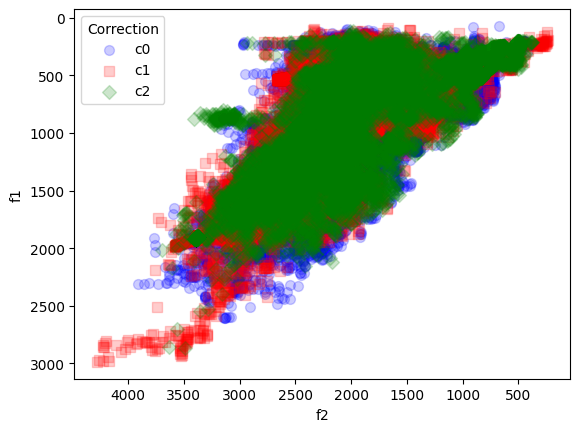

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# Define the color and shape mapping for each unique correction
color_mapping = {'c0': 'blue', 'c1': 'red', 'c2': 'green'}
shape_mapping = {'c0': 'o', 'c1': 's', 'c2': 'D'}  # 'o' = circle, 's' = square, 'D' = diamond

# Create the plot
fig, ax = plt.subplots()
for correction in formants_df['correction'].unique():
    subset = formants_df[formants_df['correction'] == correction]
    plt.scatter(subset['f2_clean'], subset['f1_clean'],
                color=color_mapping[correction],
                marker=shape_mapping[correction],
                s=50,
                label=correction,
                alpha=0.2)

# Reverse axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Labels
plt.xlabel('f2')
plt.ylabel('f1')

# Add legend for colors and shapes
plt.legend(title="Correction")
plt.show()


## 2d convex hull

The area of the convex hull is: 2742338.44 square units


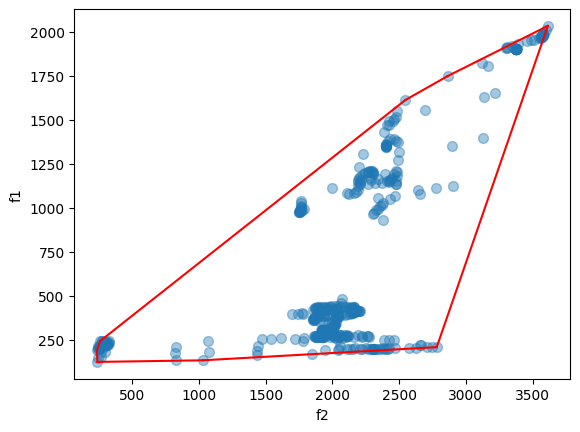

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

sample = filestotrack[15]
df = pd.read_csv(sample)

# Assuming df is your DataFrame with columns 'f1_clean' and 'f2_clean'
sample_df = df[['f2_clean', 'f1_clean']].values

# drop nans
sample_df = sample_df[~np.isnan(sample_df).any(axis=1)]

# Calculate the convex hull
hull = ConvexHull(sample_df)

# Calculate the area of the convex hull
hull_area = hull.volume  # For 2D, volume is the area

# Print the area
print(f"The area of the convex hull is: {hull_area:.2f} square units")

# Create the plot
fig, ax = plt.subplots()

# Scatter plot
plt.scatter(sample_df[:, 0], sample_df[:, 1], s=50, alpha=0.4)

# Reverse axes (since f1 and f2 are typically inverted in such plots)
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(sample_df[simplex, 0], sample_df[simplex, 1], 'r-')

# Labels
plt.xlabel('f2')
plt.ylabel('f1')

# Show plot
plt.show()


## 3d space

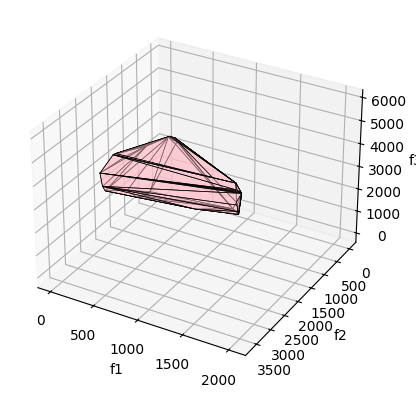

In [172]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Step 1: Load your data
# Replace 'your_data.csv' with the path to your CSV file
sample_df = pd.read_csv(filestotrack[15])


# Step 2: Extract columns and prepare points
# Assuming your DataFrame has columns named 'f1', 'f2', 'f3'
points = sample_df[['f1_clean', 'f2_clean', 'f3_clean']].values

# drop nans
points = points[~np.isnan(points).any(axis=1)]

# Step 3: Compute the convex hull
hull = ConvexHull(points)

# Step 4: Visualize the convex hull
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the convex hull
for simplex in hull.simplices:
    poly = Poly3DCollection([points[simplex]], alpha=0.5, linewidths=0.5, edgecolors='black', facecolors='pink')
    ax.add_collection3d(poly)

# Optional: plot the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o', s=0)

# flip f2 axis#
ax.invert_yaxis()

ax.set_xlabel('f1')
ax.set_ylabel('f2')
ax.set_zlabel('f3')
plt.show()


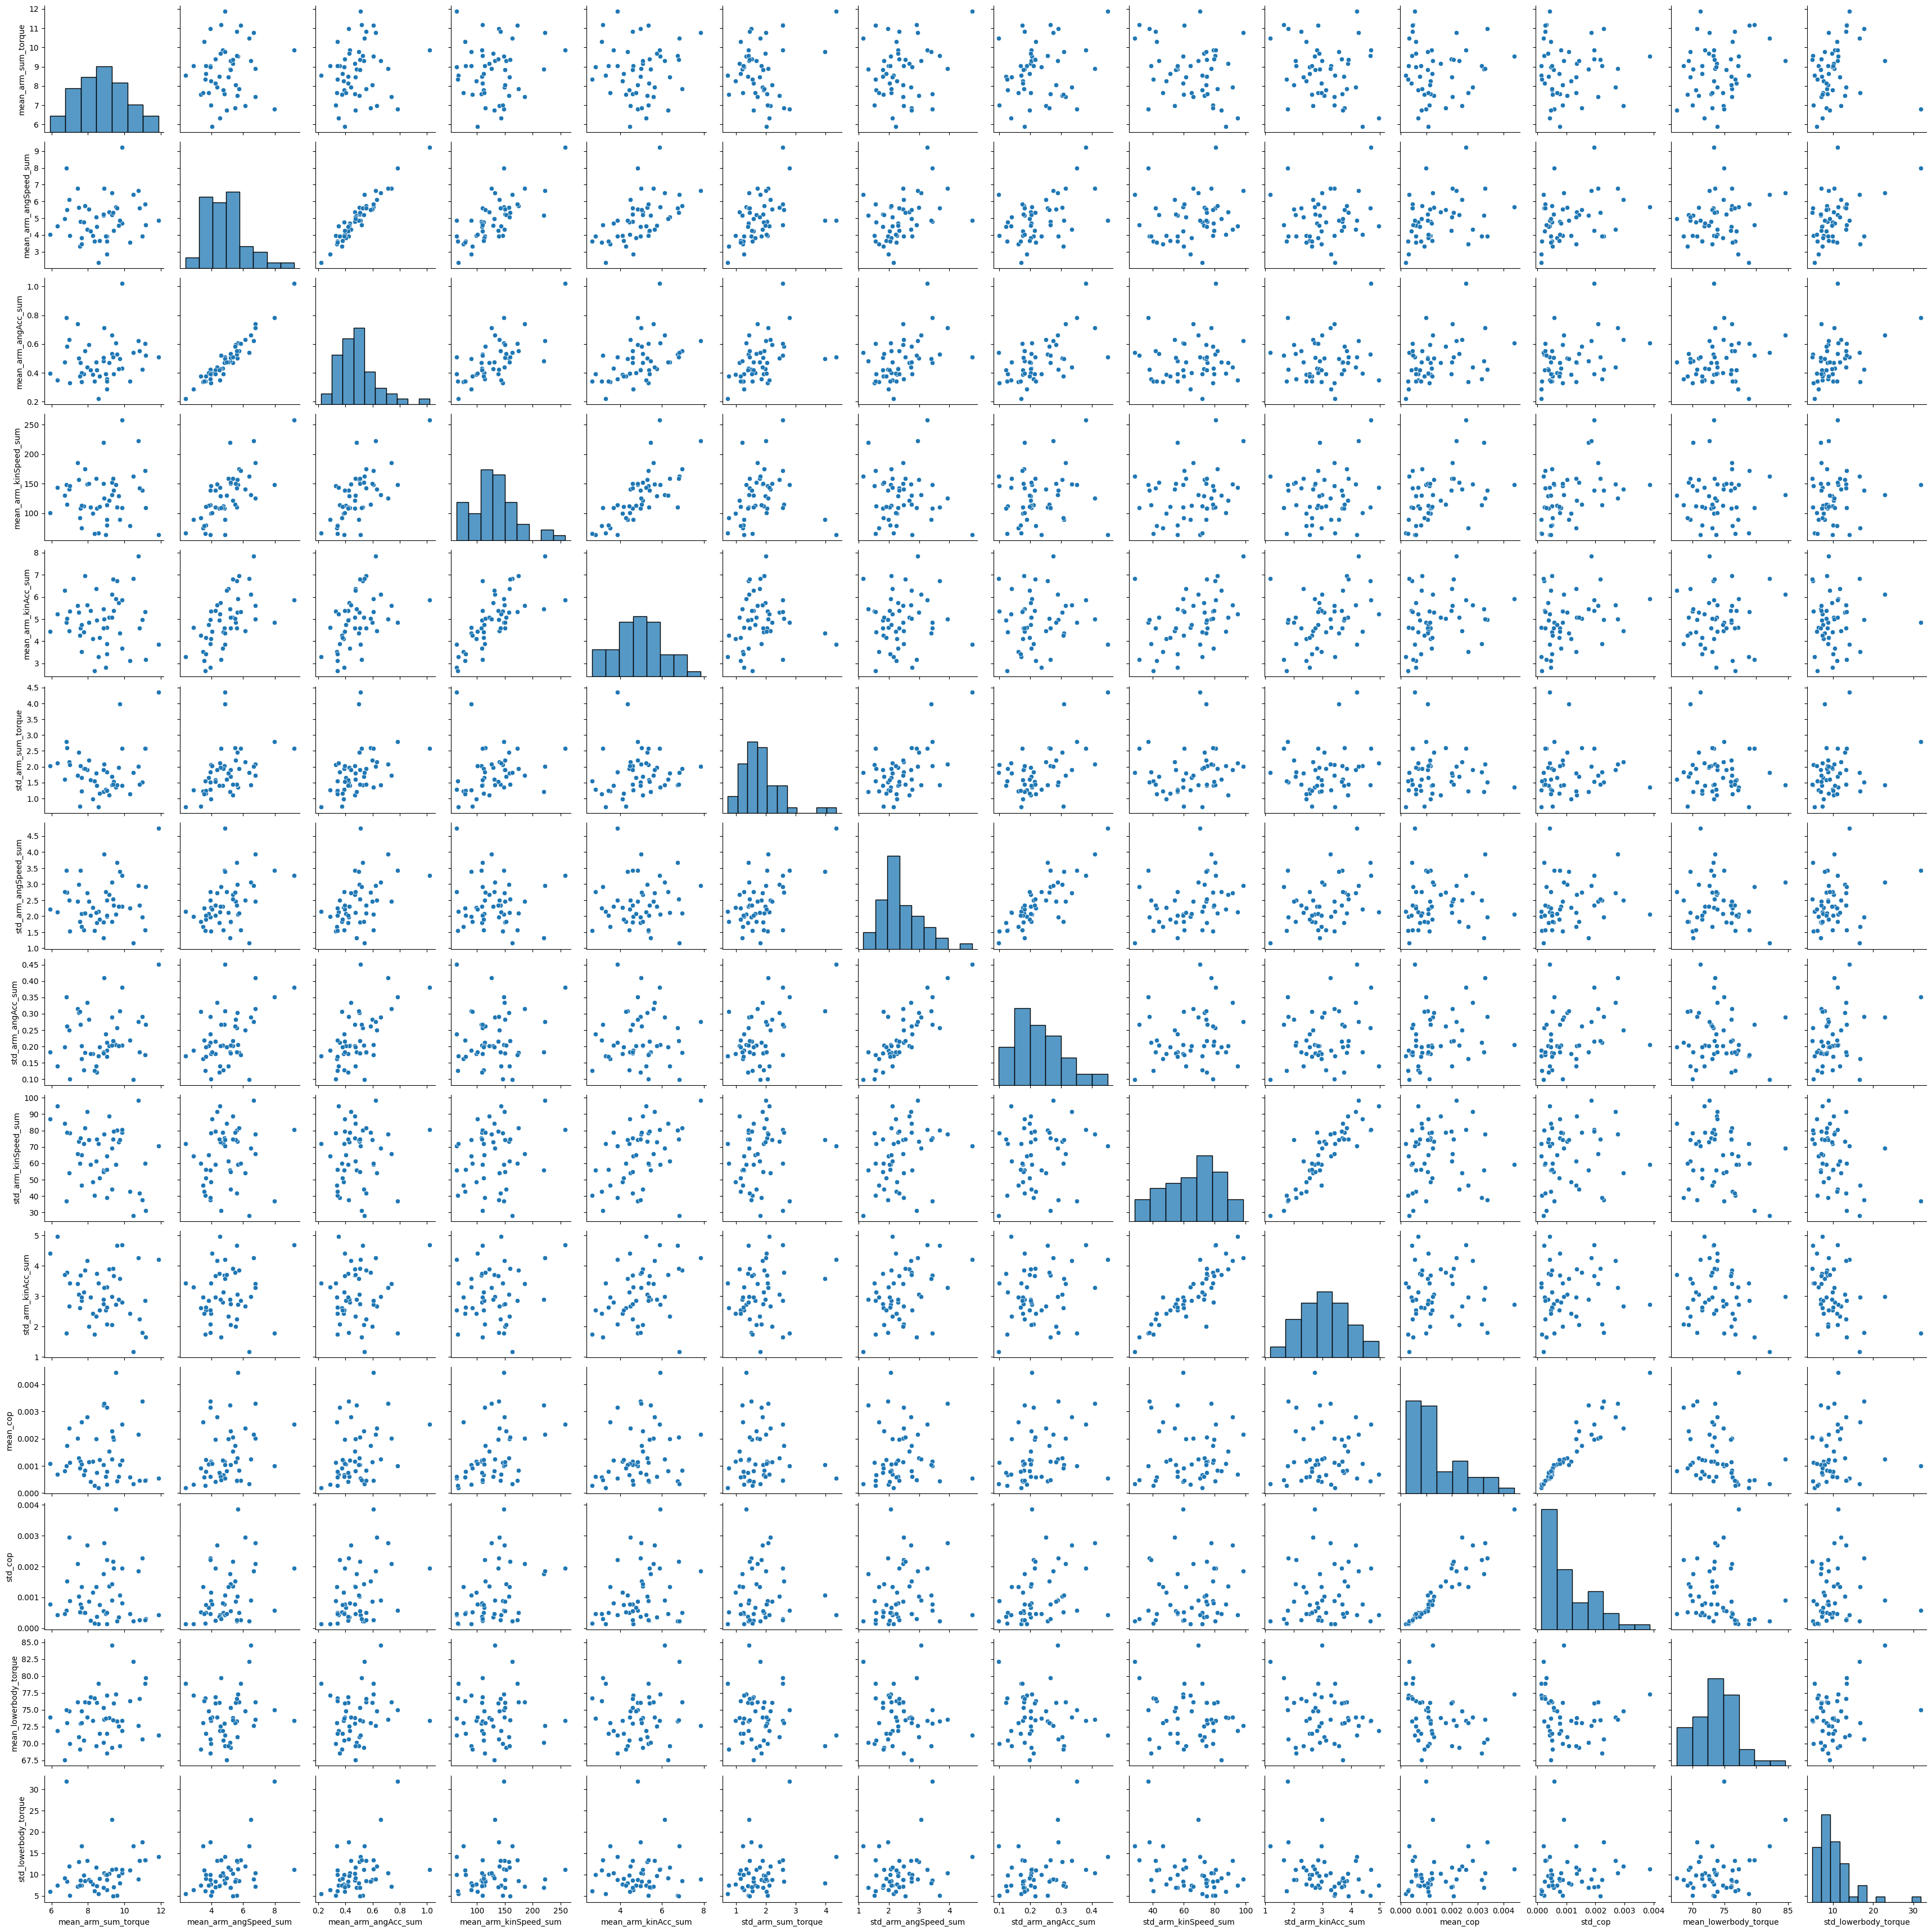

In [ ]:
## ADD CORELATION PLOT
# plot as scatterplots
sns.pairplot(resultsdf_num)
plt.show()


# Loop to extract features

Now we will loop through each file (representing a trial) and extract the features

In [ ]:
def get_statistics(cols, subdf, dictionary, duration):
    for col in cols:

        #duration_group = subdf["time"].iloc[-1] - subdf["time"].iloc[0]

        Gmean = subdf[col].mean()
        Gstd = subdf[col].std()
        peaks, _ = find_peaks(subdf[col], height=subdf[col].mean(), distance=200)
        # find the values of the peaks
        peaks_values = df.loc[peaks, col]
        # times of the peaks
        peaks_times = df.loc[peaks, "time"].tolist()

        # mean, std, len
        peak_mean = peaks_values.mean()
        peak_std = peaks_values.std()
        peak_n = len(peaks_values)

        # sample entropy
        ts = subdf[col]
        std_ts = np.std(ts)
        sampen = ent2.sample_entropy(ts, order=2)

        # if the col contains change and power, calculate integral #FLAGG: alsoadd speed (integralof speed is distance)
        #if 'change' in col or 'power' in col:
        integral = np.trapz(subdf[col])      # note that integral of power is work

        # else:
        #     integral = None

        # calculate range of the feature
        range = subdf[col].max() - subdf[col].min()

        # rate
        rate = Gmean / duration
        
        # save in dictionary
        dictionary[col] = [Gmean, Gstd, peak_mean, peak_std, peak_n, peaks_times, integral, sampen,range, rate]

    return dictionary

In [ ]:
features_df = pd.DataFrame()

# some stable variables
movcols = ['upper_body', 'arms', 'lower_body', 'head_mov']

# other stats
groups = ['arm', 'lowerbody', 'leg', 'head']

# make a key-value pair for each group with movcols
movcol_keys = {'arm': 'arms', 'lowerbody': 'lower_body', 'leg': 'lower_body', 'head': 'head_mov'}

# we also want group bbmv
kp_arms = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']
kp_lower = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_legs = ['RAnkle', 'RKnee', 'LAnkle', 'LKnee']
kp_head = ['Head']

kp_keys = {'arm': kp_arms, 'lowerbody': kp_lower, 'leg': kp_legs, 'head': kp_head}

balancecols = ['COPc', 'spine_torque_sum', 'pelvis_torque_sum', 'spine_torque_sum_change', 'pelvis_torque_sum_change']

voccols = ['envelope', 'envelope_change', 'f0', 'f1_clean', 'f1_clean_vel', 'f2_clean', 'f2_clean_vel', 'f3_clean', 'f3_clean_vel', 'loudness', 'novelty', 'roughness', 'flux']

### MAIN LOOP ###

for file in filestotrack:
    print('working on file: ', file)
    df = pd.read_csv(file)
    df["concept"] = df["FileInfo"].apply(lambda x: x.split("_")[1])
    df["modality"] = df["FileInfo"].apply(lambda x: x.split("_")[2])
    df["correction"] = df["FileInfo"].apply(lambda x: x.split("_")[3])
    df.drop(columns=["FileInfo"], inplace=True)
    
    ##########################
    ##### movement feat ######
    ##########################

    subdf = df[df["movement_in_trial"] == "movement"]
    if subdf.shape[0] > 0:
        # duration
        duration_mov = subdf["time"].iloc[-1] - subdf["time"].iloc[0]

        # number of articulators
        submovcols = [col for col in movcols if subdf[col].values[0] == "movement"]
        numofArt = len(submovcols)

        # prepare dictionary to store stats for body
        body_sumfeat = {}

        for group in groups:
            subsubdf = subdf[subdf[movcol_keys[group]] == "movement"]

            if subsubdf.shape[0] == 0:
                # create empty body_sumfeat_row
                body_sumfeat_row = pd.DataFrame()
                # duration is 0
                body_sumfeat_row["duration_group"] = 0
                # continue to next group
                continue
            else:
                # get the columns that contain group and sum
                cols = [col for col in subsubdf.columns if group in col and 'sum' in col or 'power' in col]
                # duration of this group
                duration_group = subsubdf["time"].iloc[-1] - subsubdf["time"].iloc[0]
            
                body_sumfeat = get_statistics(cols, subsubdf, body_sumfeat, duration_group)
                body_sumfeat[group + "_duration"] = duration_group
            
            # for col in cols:
            #     Gmean = subsubdf[col].mean()
            #     Gstd = subsubdf[col].std()
            #     peaks, _ = find_peaks(subsubdf[col], height=subsubdf[col].mean(), distance=200)
            #     # find the values of the peaks
            #     peaks_values = df.loc[peaks, col]
            #     # times of the peaks
            #     peaks_times = df.loc[peaks, "time"].tolist()

            #     # mean, std, len
            #     peak_mean = peaks_values.mean()
            #     peak_std = peaks_values.std()
            #     peak_n = len(peaks_values)

            #     # sample entropy
            #     ts = subsubdf[col]
            #     std_ts = np.std(ts)
            #     sampen = ent2.sample_entropy(ts, order=2)

            #     # if the col contains change, calculate integral
            #     if 'change' in col or 'power' in col:
            #         integral = np.trapz(subsubdf[col])      # note that integral of power is work

            #     else:
            #         integral = None

            #     # calculate average rate of the feature (feature per ms)
            #     rate = subsubdf[col].mean() / duration_group          # perhaps convert to seconds

            #     # calculate range of the feature
            #     range = subsubdf[col].max() - subsubdf[col].min()
                
            #     # save in dictionary
            #     body_sumfeat[col] = [Gmean, Gstd, peak_mean, peak_std, peak_n, peaks_times, integral, sampen, rate, range]
    
                ## intermittency from Kin measures
                speed = subsubdf[group + "_speedKin_sum"].values
                jerk = subsubdf[group + "_jerkKin_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_Kin"] = intermittency

                ## intermittency from IK measures
                speed = subsubdf[group + "_angSpeed_sum"].values
                jerk = subsubdf[group + "_angJerk_sum"].values
                intermittency = get_intermittency(jerk, speed)
                intermittency = np.log(intermittency) # natural log
                body_sumfeat[group + "_inter_IK"] = intermittency

                ## sample entropy of speedKin_sum FLAGGED isn't this already there??
                ts_speedKin_sum_col = group + "_speedKin_sum"
                ts_speedKin_sum = subsubdf[ts_speedKin_sum_col]
                std_ts = np.std(ts_speedKin_sum)
                sampen = ent2.sample_entropy(ts_speedKin_sum, order=2)
                body_sumfeat[group + "_sampEn_kin"] = sampen

                ## sample entropy of angSpeed_sum FLAGGED isn't this already there??
                ts_angSpeed_sum_col = group + "_angSpeed_sum"
                ts_angSpeed_sum = subsubdf[ts_angSpeed_sum_col]
                std_ts = np.std(ts_angSpeed_sum)
                sampen = ent2.sample_entropy(ts_angSpeed_sum, order=2)
                body_sumfeat[group + "_sampEn_IK"] = sampen
                
                ### BBMV
                bbmv_sum = get_bbmv(subsubdf, group, kp_keys)
                # get keypoints for the group
                # coordinates = [col for col in subdf.columns if any(x in col for x in ['_x', '_y', '_z'])]
                # kp = kp_keys[group]

                # colstoBBMV = [col for col in coordinates if any(x in col for x in kp)]
                # # from those, get rid of _x, _y, _z and keep only unique names
                # kincols = list(set([col.split('_')[0] for col in colstoBBMV]))

                # # get bbmv for each col
                # bbmvs = {}
                # for col in kincols:
                #     bbmv = get_bbmv(subdf, col)
                #     bbmvs[col] = bbmv
        

                # # get the sum of bbmv
                # bbmv_sum = sum(bbmvs.values())
                # # log bbmv
                # bbmv_sum = np.log(bbmv_sum)

                # save in dictionary
                #colname = group + "_bbmv"
                body_sumfeat[group + "_bbmv"] = bbmv_sum

                # get rate of bbmv
                rate = bbmv_sum / duration_group
                body_sumfeat[group + "_bbmv_rate"] = rate
            
    else:
        duration_mov = 0
        numofArt = 0
        body_sumfeat = {}

    # meake a row from the dictionary such that the first value for a key is Gmean, second Gstd, third peak_mean, fourth peak_std, fifth peak_n
    body_sumfeat_row = pd.DataFrame({key: [value] for key, value in body_sumfeat.items()})

    # for each column, create new column that will have the old name + _Gmean, _Gstd, _peak_mean, _peak_std, _peak_n
    for col in body_sumfeat_row.columns:
        # if the column is not intermittency
        if 'inter' not in col and 'sampEn' not in col and 'bbmv' not in col and 'duration' not in col:
            body_sumfeat_row[col + '_Gmean'] = body_sumfeat_row[col].apply(lambda x: x[0])
            body_sumfeat_row[col + '_Gstd'] = body_sumfeat_row[col].apply(lambda x: x[1])
            body_sumfeat_row[col + '_peak_mean'] = body_sumfeat_row[col].apply(lambda x: x[2])
            body_sumfeat_row[col + '_peak_std'] = body_sumfeat_row[col].apply(lambda x: x[3])
            body_sumfeat_row[col + '_peak_n'] = body_sumfeat_row[col].apply(lambda x: x[4])
            body_sumfeat_row[col + '_peak_times'] = body_sumfeat_row[col].apply(lambda x: x[5])
            body_sumfeat_row[col + '_integral'] = body_sumfeat_row[col].apply(lambda x: x[6])
            body_sumfeat_row[col + '_sampen'] = body_sumfeat_row[col].apply(lambda x: x[7])
            body_sumfeat_row[col + '_rate'] = body_sumfeat_row[col].apply(lambda x: x[8])
            body_sumfeat_row[col + '_range'] = body_sumfeat_row[col].apply(lambda x: x[9])
        

    # get rid of all the columns that don't have mean, std or peak in their name
    body_sumfeat_row = body_sumfeat_row[[col for col in body_sumfeat_row.columns if any(x in col for x in ['Gmean', 'Gstd', 'peak_mean', 'peak_std', 'peak_n', 'sampen', 'inter', 'sampEn', 'integral', 'peak_times', 'bbmv', 'rate', 'range', 'duration'])]]
    
    # add duration and numofArt
    body_sumfeat_row['duration_mov'] = duration_mov
    body_sumfeat_row['numofArt'] = numofArt

    # create bbmv_sum that sums all the bbmv
    bbmv_total = body_sumfeat_row[[col for col in body_sumfeat_row.columns if 'bbmv' in col]].sum(axis=1)
    # rate of bbmv_total
    bbmv_rate = bbmv_total / duration_mov
    # log bbmv_total FLAGGED it is already logged
    bbmv_total = np.log(bbmv_total)
    body_sumfeat_row['bbmv_total_log'] = bbmv_total
    body_sumfeat_row['bbmv_rate'] = bbmv_rate

    ####################
    ###### balance #####
    ####################
     
    balance_sumfeat = {}
    balance_sumfeat = get_statistics(balancecols, subdf, balance_sumfeat, duration_mov)

    # for col in balancecols:
    #     # get the peaks
    #     peaks_ind, _ = find_peaks(df[col], height=df[col].mean(), distance=200)
    #     peaks_values = df.loc[peaks_ind, col]
    #     # get the times
    #     peaks_time = df.loc[peaks_ind, "time"].tolist()
    #     # mean, std, len
    #     peak_mean = peaks_values.mean()
    #     peak_std = peaks_values.std()
    #     peak_n = len(peaks_values)
    #     Gmean = df[col].mean()
    #     Gstd = df[col].std()
    #     integral = np.trapz(df[col])

    #     # sample entropy
    #     ts = df[col]
    #     std_ts = np.std(ts)
    #     sampen = ent2.sample_entropy(ts, order=2)

    #     # rate
    #     rate = df[col].mean() / duration_mov

    #     # range
    #     range = df[col].max() - df[col].min()

    #     # save in dictionary
    #     balance_sumfeat[col] = [peaks_time, peak_mean, peak_std, peak_n, Gmean, Gstd, integral, sampen, rate, range]

    # make a row from the dictionary
    balance_sumfeat_row = pd.DataFrame({key: [value] for key, value in balance_sumfeat.items()})

    # for each column, create new column that will have the old name + _Gmean, _Gstd, _peak_mean, _peak_std, _peak_n
    for col in balance_sumfeat_row.columns:
        balance_sumfeat_row[col + '_Gmean'] = balance_sumfeat_row[col].apply(lambda x: x[4])
        balance_sumfeat_row[col + '_Gstd'] = balance_sumfeat_row[col].apply(lambda x: x[5])
        balance_sumfeat_row[col + '_peak_mean'] = balance_sumfeat_row[col].apply(lambda x: x[1])
        balance_sumfeat_row[col + '_peak_std'] = balance_sumfeat_row[col].apply(lambda x: x[2])
        balance_sumfeat_row[col + '_peak_n'] = balance_sumfeat_row[col].apply(lambda x: x[3])
        balance_sumfeat_row[col + '_peak_times'] = balance_sumfeat_row[col].apply(lambda x: x[0])
        balance_sumfeat_row[col + '_integral'] = balance_sumfeat_row[col].apply(lambda x: x[6])
        balance_sumfeat_row[col + '_sampen'] = balance_sumfeat_row[col].apply(lambda x: x[7])
        balance_sumfeat_row[col + '_rate'] = balance_sumfeat_row[col].apply(lambda x: x[8])
        balance_sumfeat_row[col + '_range'] = balance_sumfeat_row[col].apply(lambda x: x[9])

    # get rid of all the columns that don't have mean, std or peak in their name
    balance_sumfeat_row = balance_sumfeat_row[[col for col in balance_sumfeat_row.columns if any(x in col for x in ['Gmean', 'Gstd', 'peak_mean', 'peak_std', 'peak_n', 'integral', 'sampen', 'peak_times', 'rate', 'range'])]]

    ####################
    #### acoustics #####
    ####################

    # check whether column vocalization exist
    if "vocalization" not in df.columns:
        print("No vocalization column in the dataframe")
        vocfeat_row = pd.DataFrame()
    else:
        subdf = df[df["vocalization"] == "sounding"]
        subdf = subdf.reset_index(drop=True)

        if subdf.shape[0] > 0:
            # duration
            duration_voc = subdf["time"].iloc[-1] - subdf["time"].iloc[0]

            vocfeat_dict = {}
            vocfeat_dict = get_statistics(voccols, subdf, vocfeat_dict, duration_voc)

            # for feature in voccols:
            #     # get the peaks
            #     peaks_ind, _ = find_peaks(subdf[feature], height=df[feature].mean(), distance=200)
            #     peaks_values = df.loc[peaks_ind, feature]
            #     # get the times
            #     peaks_time = subdf.loc[peaks_ind, "time"].tolist()
            #     # mean, std, len
            #     peak_mean = peaks_values.mean()
            #     peak_std = peaks_values.std()
            #     peak_n = len(peaks_values)
            #     Gmean = subdf[feature].mean()
            #     Gstd = subdf[feature].std()

            #     # if the feature is envelope_change, calculate integral
            #     if 'change' in feature:
            #         integral = np.trapz(subdf[feature])
            #     else:
            #         integral = None

            #     # sample entropy
            #     ts = subdf[feature]
            #     std_ts = np.std(ts)
            #     sampen = ent2.sample_entropy(ts, order=2)

            #     # rate
            #     rate = subdf[feature].mean() / duration_voc

            #     # range 
            #     range = subdf[feature].max() - subdf[feature].min()

            #     # save in dictionary
            #     vocfeat_dict[feature] = [peaks_time, peak_mean, peak_std, peak_n, Gmean, Gstd, integral, sampen, rate, range]

        else:
            print("No vocalization in the trial")
            vocfeat_dict = {}
            duration_voc = 0

        # create a dataframe from the dictionary
        vocfeat_row = pd.DataFrame({key: [value] for key, value in vocfeat_dict.items()})

        # for each column, create new column that will have the old name + _Gmean, _Gstd, _peak_mean, _peak_std, _peak_n
        for col in vocfeat_row.columns:
            vocfeat_row[col + '_Gmean'] = vocfeat_row[col].apply(lambda x: x[4])
            vocfeat_row[col + '_Gstd'] = vocfeat_row[col].apply(lambda x: x[5])
            vocfeat_row[col + '_peak_mean'] = vocfeat_row[col].apply(lambda x: x[1])
            vocfeat_row[col + '_peak_std'] = vocfeat_row[col].apply(lambda x: x[2])
            vocfeat_row[col + '_peak_n'] = vocfeat_row[col].apply(lambda x: x[3])
            vocfeat_row[col + '_peak_times'] = vocfeat_row[col].apply(lambda x: x[0])
            vocfeat_row[col + '_integral'] = vocfeat_row[col].apply(lambda x: x[6])
            vocfeat_row[col + '_sampen'] = vocfeat_row[col].apply(lambda x: x[7])
            vocfeat_row[col + '_rate'] = vocfeat_row[col].apply(lambda x: x[8])
            vocfeat_row[col + '_range'] = vocfeat_row[col].apply(lambda x: x[9])
       
        # get rid of all the columns that don't have mean, std or peak in their name
        vocfeat_row = vocfeat_row[[col for col in vocfeat_row.columns if any(x in col for x in ['Gmean', 'Gstd', 'peak_mean', 'peak_std', 'peak_n', 'integral', 'peak_times', 'sampen', 'rate', 'range'])]]
        # add duration
        vocfeat_row['duration_voc'] = duration_voc

        # if f1 f2 and f3 are not only nan, calculate the volume of the convex hull
        if subdf['f1_clean'].isnull().all() and subdf['f2_clean'].isnull().all() and subdf['f3_clean'].isnull().all():
            print("No f1, f2, f3 in the dataframe")
            vocfeat_row['VSA_f1f2'] = None
            vocfeat_row['VSA_f1f2f3'] = None
        else:
            VSA2d, VSA3d = getVSA(subdf)
            # f1_clean = subdf['f1_clean'].dropna()
            # f2_clean = subdf['f2_clean'].dropna()

            # # get the convex hull
            # points = np.array([f1_clean, f2_clean]).T
            # hull = ConvexHull(points)
            # volume = hull.volume
            # volume = np.log(volume) # natural log

            # save in vocfeat_row
            vocfeat_row['VSA_f1f2'] = VSA2d

            # get it also for f1, f2, and f3
            # f3_clean = subdf['f3_clean']
            # # get rid of nans
            # f3_clean = f3_clean.dropna()

            # # get the convex hull
            # points = np.array([f1_clean, f2_clean, f3_clean]).T
            # hull = ConvexHull(points)
            # # get the volume of the convex hull
            # volume = hull.volume
            # log it
            # volume = np.log(volume)

            # save in vocfeat_row
            vocfeat_row['VSA_f1f2f3'] = VSA3d

    # concatenate bodyrow, coprow, and vocrow
    newrow_concat = pd.concat([body_sumfeat_row, balance_sumfeat_row, vocfeat_row], axis=1)

    ## synchrony FLAGGED - here perhaps necessary to take wrist, not the aggregated arm
    # prepare a list to store the syncs
    syncs = []
    if 'arm_accKin_sum_peak_times' not in newrow_concat.columns:
        print("No arm_accKin_sum_peak_times in the dataframe")
        syncs = None
    else:
        acc_peak_times = newrow_concat['arm_accKin_sum_peak_times'][0]

        if len(acc_peak_times) == 0:
            print("No peaks in arm_accKin_sum")
            syncs = None
        else:
            # arm_accKin_sum_peak_times is a list so we will loop over it
            for acc_peak_time in acc_peak_times:
                # if there are no peaks, we will put None
                # if len(acc_peak_time) == 0:
                #     sync = None
                # else:
                # check if the col exist
                if 'f0_peak_times' not in newrow_concat.columns:
                    print("No f0_peak_times in the dataframe")
                    sync = None
                else:
                    # get the closest peak in envelope
                    env_peak_times = newrow_concat['f0_peak_times'][0]
                    # if there are no peaks in envelope, we will put None
                    if len(env_peak_times) == 0:
                        sync = None
                    else:
                        # prepare list to store the closeness
                        closeness = []

                        # loop over the list of peak_times
                        for env_peak_time in env_peak_times:
                            # check how close is env_peak_time to peak_time
                            close = abs(env_peak_time - acc_peak_time)
                            # append the closeness to the list
                            closeness.append(close)

                        # get the index of the closest peak
                        closest_peak_ind = closeness.index(min(closeness))
                        # get the time of the closest peak
                        closest_peak_time = env_peak_times[closest_peak_ind]
                        # get the time difference
                        sync = closest_peak_time - acc_peak_time

            # append the sync to the list
            syncs.append(sync)


    # add the syncs to the newrow_concat
    newrow_concat['armAcc_f0_sync'] = syncs

    ### peaks in arms
    # only for where arms are moving
    subdf = df[df["arms"] == "movement"]
    # reset index
    subdf = subdf.reset_index(drop=True)

    # prepare dictionary to store the values
    armfeatures_dict = {}

    # arms columns
    arms_col = ['Wrist', 'wrist', 'Elbow', 'elbow', 'Shoulder', 'shoulder', 'arm']
    # get columns in subdf that contains arms_col in their name
    arms_col = [col for col in df.columns if any(arm in col for arm in arms_col)]
    # get rid of columns that do not contain speed, acc, or moment
    arms_col = [col for col in arms_col if any(x in col for x in ['speed', 'acc', 'moment'])]

    ## cols for intermittency
    intercols = ['RWrist', 'RElbow', 'RShoulder', 'LWrist', 'LElbow', 'LShoulder']

    if subdf.shape[0] == 0:
        print("No movement in arms")
        arms_submov = 0       
        # append the number of submovements in wrist
        duration_arms = 0
        newrow_arms = pd.DataFrame()    
        newrow_arms['arms_submovements'] = [arms_submov]
        #newrow_arms['arms_duration'] = [duration_arms]
        newrow_arms['Wrist_tempVar'] = 0

    else:

        # count submovements in wrist
        submovcols = [col for col in subdf.columns if "Wrist" in col and 'speed' in col]
        submovs = []
        tempVars = []
        for col in submovcols:
            peaks, _ = find_peaks(subdf[col], height=df[col].mean(), distance=150)
            # submovements
            submovs.append(len(peaks))
            
            # temporal variability
            peak_times = df.loc[peaks, "time"]
            intervals = np.diff(peak_times)
            tempVar = np.std(intervals)
            tempVars.append(tempVar)

        arms_submov = sum(submovs)
        wrists_tempVar = sum(tempVars)

        #duration_arms = subdf["time"].iloc[-1] - subdf["time"].iloc[0]

        # create a dataframe with bbmv, duration, and submovements
        newrow_arms = pd.DataFrame()    
        newrow_arms['arms_submovements'] = [arms_submov]
        #newrow_arms['arms_duration'] = [duration_arms]
        newrow_arms['Wrist_tempVar'] = [wrists_tempVar]

    ### motor complexity
    # from pca df get the row that has the same TrialID
    pca_row = pca[pca["TrialID"] == df["TrialID"].values[0]]
    pca_row = pca_row.reset_index(drop=True)
   
    # concatenate newrow and newrow_arms
    newrow_final = pd.concat([newrow_concat, newrow_arms, pca_row], axis=1)

    # add trial info
    newrow_final["TrialID"] = df["TrialID"].values[0]
    newrow_final["concept"] = df["concept"].values[0]
    newrow_final["modality"] = df["modality"].values[0]
    newrow_final["correction"] = df["correction"].values[0]

    # concatenate
    features_df = pd.concat([features_df, newrow_final], ignore_index=True)

    # get rid of all cols that have only None (integrals of some features)
    features_df = features_df.dropna(axis=1, how='all')

    ### answer info
    index = int(df["TrialID"].values[0].split("_")[2])
    concept = df["concept"].values[0]

    # check what was the answer and cosine similarity for the index
    answer_fol = similaritydata[similaritydata["index"] == index]["answer"].values[0]
    answer_fol_sim = similaritydata[similaritydata["index"] == index]["cosine_similarity"].values[0]

    # check what was the answer and cosine similarity for index before - but only if the previous index has the same concept as the current one
    if index - 1 in similaritydata["index"].values and similaritydata[similaritydata["index"] == index - 1]["word"].values[0] == concept:
        answer_prev = similaritydata[similaritydata["index"] == index - 1]["answer"].values[0]
        answer_prev_sim = similaritydata[similaritydata["index"] == index - 1]["cosine_similarity"].values[0]
    else:
        print("previous index doesn't have the same concept")
        answer_prev = None
        answer_prev_sim = None

    # append to the features_df
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "answer_fol"] = answer_fol
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "answer_fol_dist"] = answer_fol_sim
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "answer_prev"] = answer_prev
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "answer_prev_dist"] = answer_prev_sim

    # check what is the expressibility (fit in express_df) for the concept&modality
    express = express_df[(express_df["word"] == concept) & (express_df["modality"] == df["modality"].values[0])]["fit"].values[0]
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "expressibility"] = express

    ## add response time from answerdata
    response_time = answerdata[answerdata["TrialID"] == df["TrialID"].values[0]]["response_time_sec"].values[0]
    features_df.loc[features_df["TrialID"] == df["TrialID"].values[0], "response_time_sec"] = response_time

# create a concept id to group together corrections of one concept
for row in features_df.iterrows():
    row = row[1]
    features_df.loc[row.name, "concept_id"] = row["concept"] + "_" + row["modality"] + "_" + row["TrialID"].split("_")[-1]

## save the features_df
features_df.to_csv("features_df.csv", index=False)

## Handle corrections

In [117]:
# which concept_id has in correction only c0, but not c1 and c2

c0 = features_df[features_df["correction"] == "c0"]["concept_id"].unique()
c1 = features_df[features_df["correction"] == "c1"]["concept_id"].unique()
c2 = features_df[features_df["correction"] == "c2"]["concept_id"].unique()

# which concept_id is only in c0
only_c0 = [x for x in c0 if x not in c1 and x not in c2]
print(only_c0)
c0_c1 = [x for x in c0 if x in c1 and x not in c2]
print(c0_c1)
all_c = [x for x in c0 if x in c1 and x in c2]
print(all_c)

# make subf from features_df with concept_ids that are in all_c

subfeat3 = features_df[features_df["concept_id"].isin(all_c)]
subfeat2 = features_df[features_df["concept_id"].isin(c0_c1)]

# merge
subfeat_c = pd.concat([subfeat3, subfeat2], ignore_index=True)

# add column correction_info to features_df
features_df["correction_info"] = features_df["correction"]

# if the concept_id is in only_c0, then correction_info is c0_only
features_df.loc[features_df["concept_id"].isin(only_c0), "correction_info"] = "c0_only"

# save it
features_df.to_csv("features_df_final.csv", index=False)


['ik_combinatie_p0', 'kauwen_combinatie_p0', 'vis_combinatie_p1', 'ruiken_combinatie_p1', 'wind_combinatie_p1', 'vogel_gebaren_p0', 'vuur_gebaren_p0', 'horen_gebaren_p0', 'blazen_gebaren_p1', 'kat_gebaren_p1', 'lachen_gebaren_p1', 'slapen_gebaren_p1', 'vallen_geluiden_p0']
['goed_gebaren_p0', 'geven_gebaren_p1', 'zwaar_geluiden_p1']
['vrouw_combinatie_p0', 'verbranden_combinatie_p0', 'groot_combinatie_p1', 'hoog_combinatie_p1', 'blij_combinatie_p1', 'heet_combinatie_p1', 'water_gebaren_p0', 'ver_gebaren_p0', 'zoet_gebaren_p1', 'geur_geluiden_p0', 'vlieg_geluiden_p0', 'scherp_geluiden_p0', 'staart_geluiden_p0', 'piepen_geluiden_p0', 'jagen_geluiden_p0']


C:\Users\kadava\AppData\Local\Temp\ipykernel_27152\184445693.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df["correction_info"] = features_df["correction"]


# Cleaning

In [20]:
# get rid of all tjhe columns that contain Kin or kin string
features_df_clean = features_df[[col for col in features_df.columns if 'Kin' not in col and 'kin' not in col]]

# which of the columns have more than 50% of missing values

missing_values = features_df_clean.isnull().mean()
missing_values = missing_values[missing_values > 0.5]


# print missing values completely
print(missing_values)

# get rid of the columns that have more than 50% of missing values
features_df_clean2 = features_df_clean[[col for col in features_df_clean.columns if col not in missing_values.index]]

lowerbody_duration       0.531250
lowerbody_inter_IK       0.531250
lowerbody_sampEn_IK      0.531250
lowerbody_bbmv           0.531250
lowerbody_bbmv_rate      0.531250
                           ...   
f2_clean_vel_peak_std    0.859375
novelty_peak_std         0.953125
f2_clean_peak_std        0.921875
f0_peak_std              0.984375
loudness_peak_std        0.984375
Length: 127, dtype: float64


# UMAP

In [ ]:
feat_df = features_df_clean2.copy()

# make different umap for each modality     ## FLAGGED leave it for all modalities and plot corrections and modalities
modality = 'geluiden'
# get only the rows with the modality
features_df_red = feat_df[feat_df["modality"] == modality]

# replace all NaN values with 0
features_umap = features_df_red.fillna(0)

In [22]:
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()

# get only numeric columns
features_df_num = features_umap._get_numeric_data()

# drop NAs
features_df_num = features_df_num.dropna()

# z-score all columns
features_df_scaled = StandardScaler().fit_transform(features_df_num)

# fit umap
embedding = reducer.fit_transform(features_df_scaled)
embedding.shape

c:\Users\kadava\AppData\Local\anaconda3\envs\TSPROCESS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Input X contains infinity or a value too large for dtype('float64').

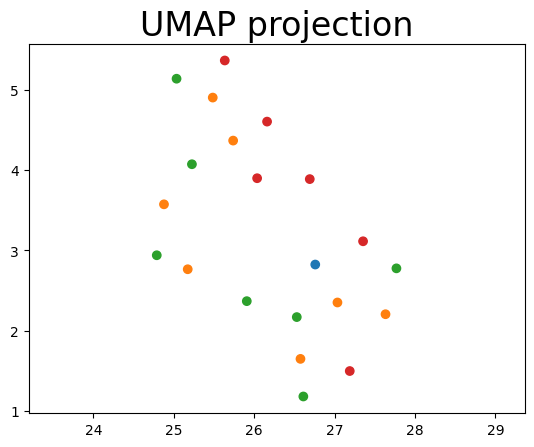

In [108]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in features_umap.correction_info.map({'c0_only': 0, "c0":1, "c1":2, "c2":3})]) # blue for c0, orange for c1, green for c2
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

Text(0.5, 1.0, 'UMAP projection')

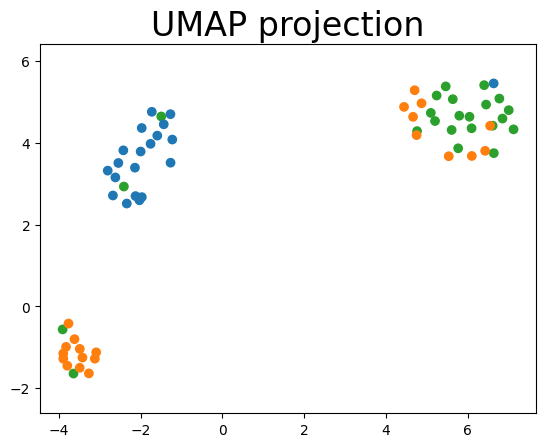

In [75]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in features_umap.modality.map({"gebaren":0, "geluiden":1, "combinatie":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

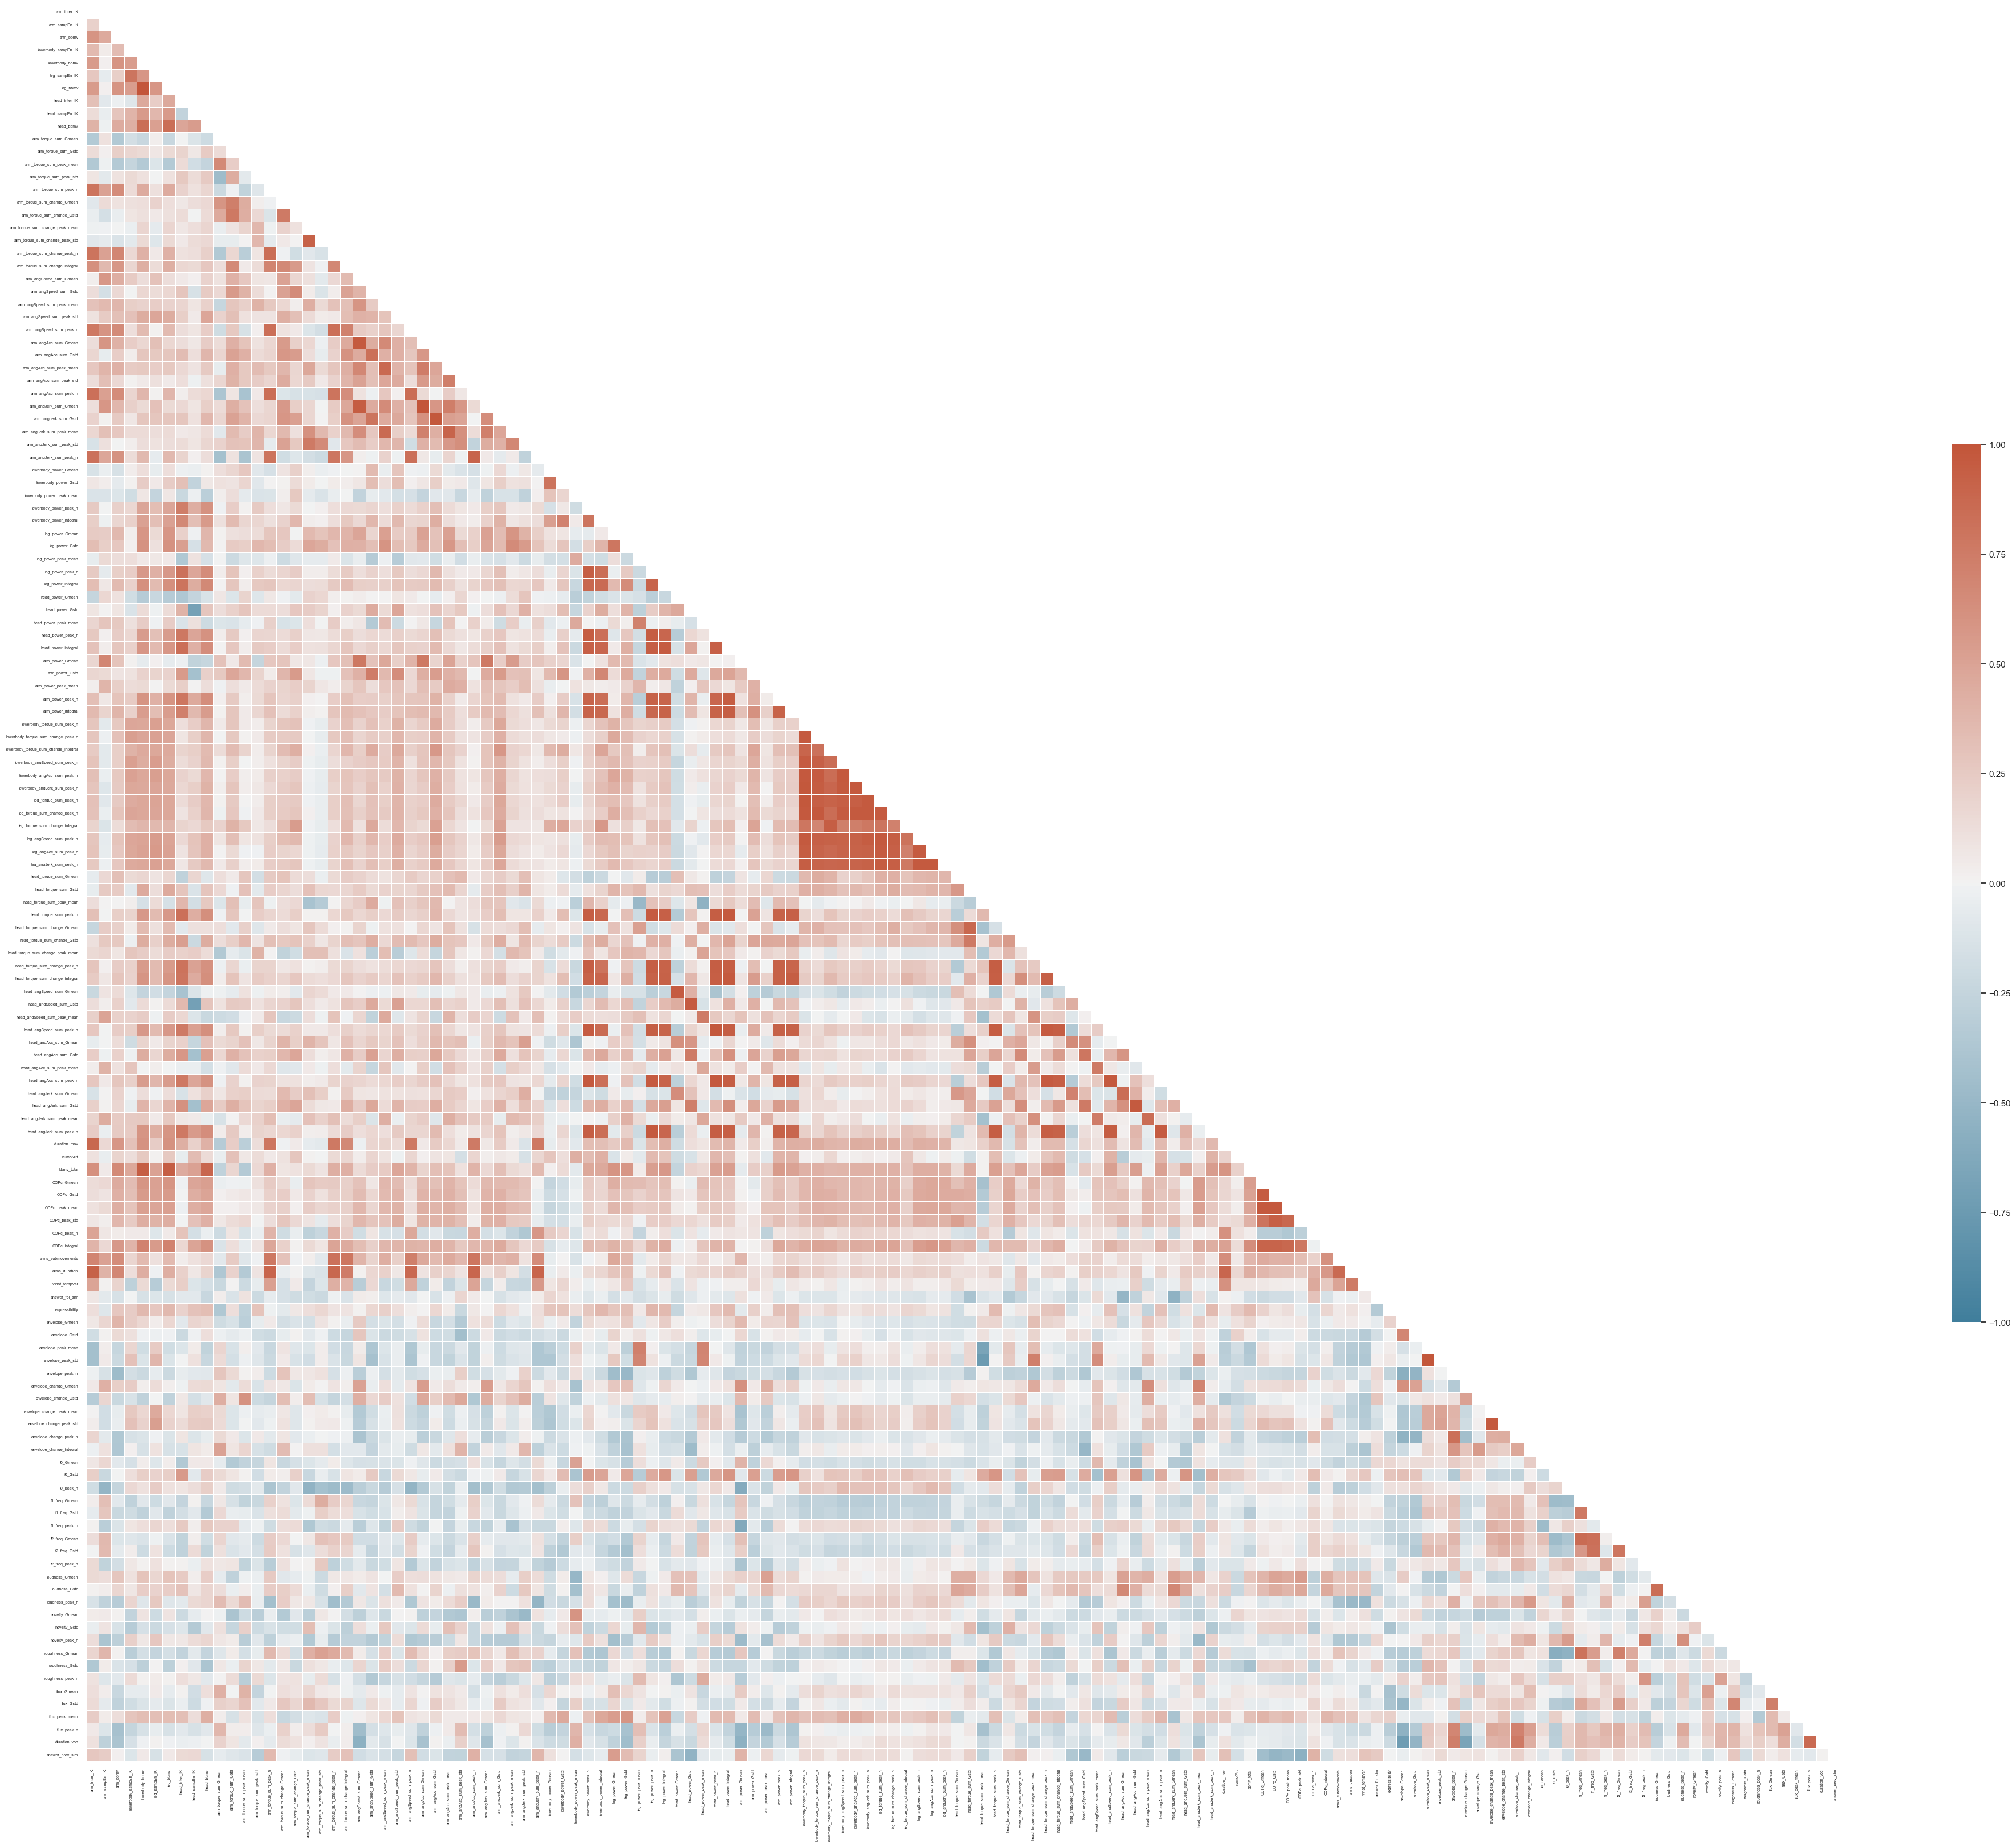

In [203]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

df = features_df_clean2
# Leave only numeric columns
df = df.select_dtypes(include=['float64', 'int64'])

d = df

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure with a larger size
f, ax = plt.subplots(figsize=(50,40))  # Increase the size for better readability

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5, "aspect": 30})

# Adjust the font size and rotation of the labels
plt.xticks(fontsize=5, rotation=90)  # Rotate x labels
plt.yticks(fontsize=5, rotation=0)   # y labels remain horizontal

plt.show()


# Effort as a rate

## Normalizing the original feature df

In [22]:
import pandas as pd

features_df = pd.read_csv("features_df_final.csv")

# create new column participant and fill it with last element of TrialID   
features_df["participant"] = features_df["TrialID"].apply(lambda x: x.split("_")[-1])

# loop over columns in the df
for col in features_df.columns:
    # if the column is numerical, continue, if not, skip
    if features_df[col].dtype != 'float64':
        continue
    else:
        # get the mean value for each participant separately
        mean_val = features_df.groupby("participant")[col].mean()
        # get the max value for each participant separately
        max_val = features_df.groupby("participant")[col].max()
        # create new col with _rel and center the values on the mean of the participant
        features_df[col + "_norm"] = features_df.apply(lambda x: x[col] - mean_val[x["participant"]], axis=1)
        # create new col with _norm and normalize the values based on the max of the participant
        features_df[col + "_rel"] = features_df.apply(lambda x: x[col] / max_val[x["participant"]], axis=1)


# save it
features_df.to_csv("features_df_final_with_rel.csv", index=False)

C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_724\1935741208.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[col + "_norm"] = features_df.apply(lambda x: x[col] - mean_val[x["participant"]], axis=1)
C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_724\1935741208.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[col + "_rel"] = features_df.apply(lambda x: x[col] / max_val[x["participant"]], axis=1)
C:\Users\Sarka Kadava\AppData\Local\Temp\ipykernel_724\1935741208.py:19: PerformanceWarning: D

TODO


- measure for synchronization
- think of how to get a prominent features for a concept (PCA?)
- 0_2_42 annotation is missing